# FIGARO in a python script

This notebook shows how to include FIGARO in a `python` script. If you are a casual user or you are simply interested in performing a DPGMM/(H)DPGMM reconstruction, you may want to make use of the turnkey command-line scripts already provided with FIGARO (`figaro-density` and `figaro-hierarchical`): please refer to the *Quick start* page for more details.

## 1D probability density

We will start from a simple problem: inferring a 1D probability density given a set of samples drawn from it.
Let's draw some samples from a Gaussian distribution.

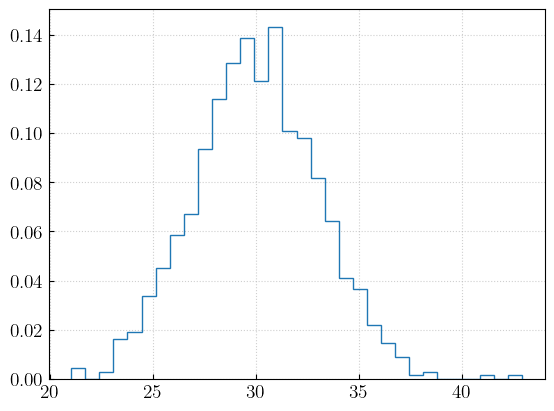

In [1]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from tqdm import tqdm
from figaro import plot_settings
%matplotlib inline

mu = 30
sigma = 3
n_samps = 1000
dist = norm(mu, sigma) 

samples = dist.rvs(n_samps)

n, b, p = plt.hist(samples, histtype = 'step', density = True)

FIGARO contains a class designed to infer probability densities given a set of samples.

In order to instantiate the class, we need to specify the boundaries of the distribution.
We will assume that our probability density is bounded between 10 and 50. Moreover, we will make use of the available samples to set some reasonable priors for the mean and variance of each Gaussian component fo the mixture making use of the `get_priors` method. More details on this function are given below.

In [2]:
from figaro.mixture import DPGMM
from figaro.utils import get_priors

x_min = 10
x_max = 50
bounds = [x_min, x_max]
prior_pars = get_priors(bounds = bounds, samples = samples)

mix = DPGMM(bounds, prior_pars = prior_pars)

The idea is that the algorithm *learns* the shape of the probability density from the available samples, one at a time: every new sample adds a piece of information to the inference. Therefore, we need to pass the samples to our mixture one at a time in order to draw a single realisation of the Dirichlet Process.

In [3]:
for s in tqdm(samples):
    mix.add_new_point(s)

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 169.04it/s]


Now that our mixture knows the shape of the distribution, we can build the probability density:

In [4]:
rec = mix.build_mixture()

Before starting again with a new inference the mixture must be initialised, otherwise it will remember the samples from the previous run.

In [5]:
mix.initialise()

**Please note:** the mixture we just inferred is stored in `rec`. Calling any of the following methods on the now empty mixture `mix` will raise an exception.\
Let's have a look at this reconstruction: `rec` contains the realisation we just drew, with some useful methods.

In [6]:
[method_name for method_name in dir(rec)
                  if callable(getattr(rec, method_name)) and not method_name.startswith('_')]

['cdf',
 'condition',
 'fast_logpdf',
 'fast_pdf',
 'gradient',
 'log_gradient',
 'logcdf',
 'logpdf',
 'marginalise',
 'pdf',
 'rvs']

`pdf` and `logpdf` take a 1D or 2D array and return, respectively, the probability and the log_probability of the inferred distribution, while `rvs` takes the number of desiderd samples and returns an array of draws. `cdf` and `logcdf` are the cumulative distribution function and its logarithm. These are, however, defined only for 1D distributions. `fast_pdf` and `fast_logpdf` take a single point (1D array) and return the pdf/logpdf for that specific point without relying on NumPy. These functions are thought for MCMCs and nested samplings. `marginalise` and `condition` makes use of the properties of the multivariate Gaussian distribution to analytically marginalise or condition the inferred distribution on some of its variables. 

An instance of the `figaro.mixture.mixture` class behave mostly like a `scipy.stats` class:

In [7]:
pt = 30
print(rec.pdf(pt), rec.logpdf(pt), rec.cdf(pt), rec.rvs())

[0.10989248] [-2.20825284] [[0.50104709]] [[26.83161485]]


We now want to evaluate the probability density over the interval $[x_{min},x_{max}]$.   
**WARNING: FIGARO uses a coordinate change that is singular at boundaries. The distribution is defined to be zero outside bounds.** This transformation is used to ensure that the conditions for the GMM to be a good approximant for arbitrary probability densities ([Nguyen et al 2012](https://www.tandfonline.com/doi/full/10.1080/25742558.2020.1750861)) are met. If you don't want to make use of this transformation, set `probit = False` while instantiating the DPGMM class.

In [8]:
x = np.linspace(x_min, x_max, 1000)
p = rec.pdf(x)

Let's compare the reconstruction with the samples and with the true distribution:

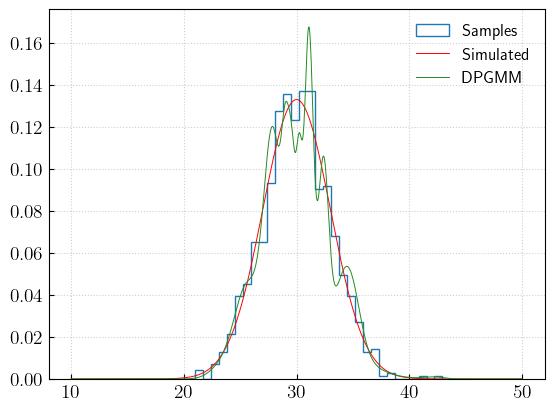

In [9]:
n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p, color = 'forestgreen', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)
plt.show()

This is a *single* realisation from the Dirichlet Process. In order to properly explore the distribution space, we need a set of draws: therefore we need to repeat the exercise of training the DPGMM for every new sample we want. 

The DPGMM class contains a method that is a wrapper for the `for` loop we wrote before, `DPGMM.density_from_samples()`, which returns a realisation from the DP.

In [10]:
n_draws = 100
draws = np.array([mix.density_from_samples(samples) for _ in tqdm(range(n_draws))])

100%|█████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Each call to `density_from_samples` reshuffles the samples and automatically initialise the mixture at the end.

With the set of draws we have, we can compute median and credible regions for the probability distribution.

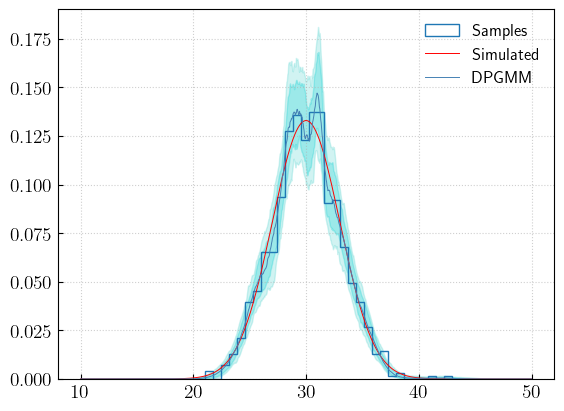

In [11]:
probs = np.array([d.pdf(x) for d in draws])

percentiles = [50, 5, 16, 84, 95]
p = {}
for perc in percentiles:
    p[perc] = np.percentile(probs, perc, axis = 0)
N = p[50].sum()*(x[1]-x[0])
for perc in percentiles:
    p[perc] = p[perc]/N

n, b, t = plt.hist(samples, bins = int(np.sqrt(len(samples))), histtype = 'step', density = True, label = 'Samples')
plt.fill_between(x, p[95], p[5], color = 'mediumturquoise', alpha = 0.25)
plt.fill_between(x, p[84], p[16], color = 'darkturquoise', alpha = 0.25)
plt.plot(x, dist.pdf(x), color = 'red', lw = 0.7, label = 'Simulated')
plt.plot(x, p[50], color = 'steelblue', label = 'DPGMM')
plt.legend(loc = 0, frameon = False)
plt.grid(alpha = 0.6)   

The same plot can be obtained with the dedicated method:

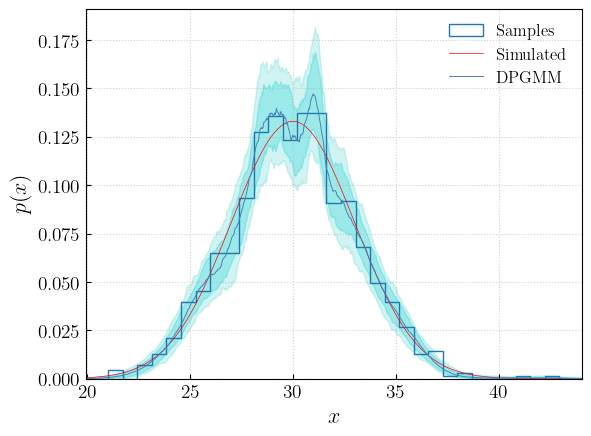

In [12]:
from figaro.plot import plot_median_cr
fig = plot_median_cr(draws,
               injected = dist.pdf,
               samples  = samples,
               save     = False,
               show     = True,
               )

The draws are uncorrelated from each other. The autocorrelation function is:

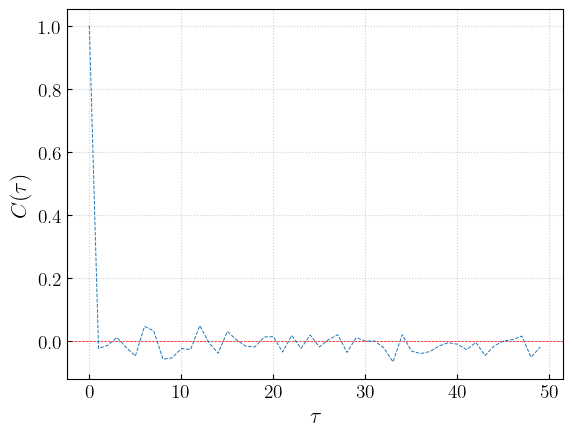

In [13]:
from figaro.diagnostic import autocorrelation
acf = autocorrelation(draws, bounds = [20, 40], save = False, show = True)

Let's look at the entropy to assess the convergence of the recovered distribution to the injected one.\
In order to do so, we need to draw a single realisation, saving it every time we add a new sample.

In [14]:
mix.initialise()
updated_mixture = []

for s in tqdm(samples):
    mix.add_new_point(s)
    updated_mixture.append(mix.build_mixture())

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 174.63it/s]


Once we have all the history of how the single distribution has been generated, the FIGARO package comes with a method that produces entropy plots:

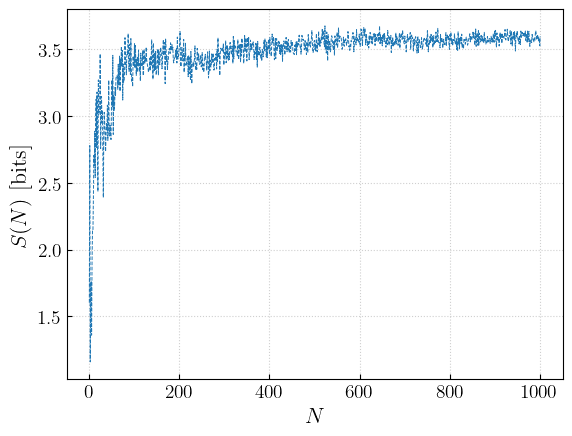

In [15]:
from figaro.diagnostic import entropy

S = entropy(updated_mixture, show = True, save = False)

It is also possible to compute an approximant of the entropy derivative to assess whether the distribution converged or not.

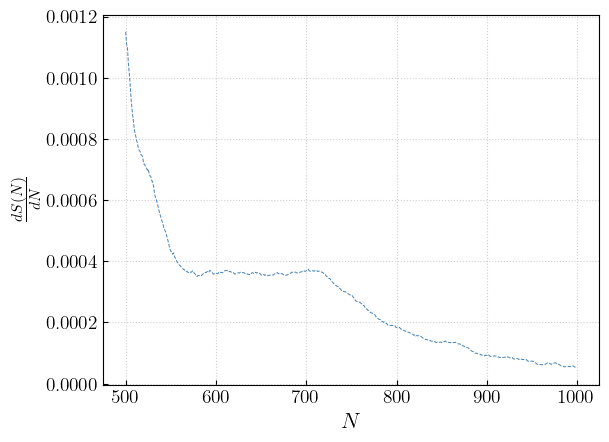

In [16]:
from figaro.diagnostic import plot_angular_coefficient

ac = plot_angular_coefficient(S, show = True, save = False)

When the number of accumulated samples is large enough to provide a good representation of the underlying distribution. the entropy reaches a plateau, and its derivative fluctuates around zero.\
Let's repeat the exercise with a larger number of samples:

In [17]:
n_samps = 5000
samples = dist.rvs(n_samps)

mix.initialise()
updated_mixture = []

for s in tqdm(samples):
    mix.add_new_point(s)
    updated_mixture.append(mix.build_mixture())

100%|██████████████████████████████████████| 5000/5000 [00:36<00:00, 136.74it/s]


Let's look at the recovered distribution:

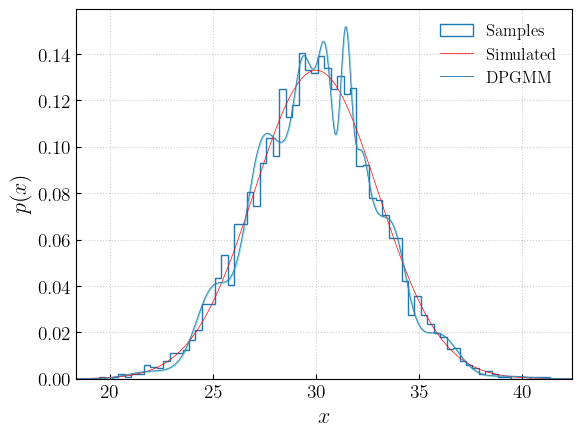

In [18]:
fig = plot_median_cr([updated_mixture[-1]],
               injected = dist.pdf,
               samples  = samples,
               save     = False,
               show     = True,
               )

Entropy and angular coefficient:

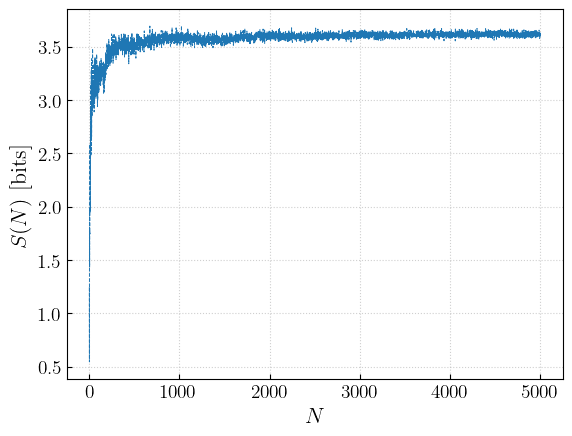

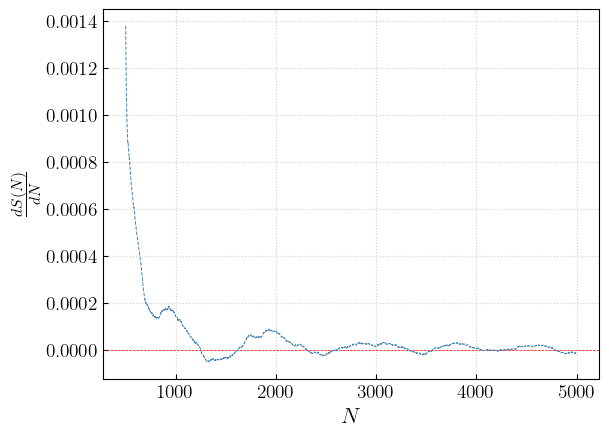

In [19]:
S  = entropy(updated_mixture, show = True, save = False)
ac = plot_angular_coefficient(S, show = True, save = False, ac_expected = 0)

With this number of samples, the angular coefficient starts fluctuating around 0 after ~3000 samples.

## Setting prior parameters

The prior distribution for means and covariances is the Normal-Inverse-Wishart distribution, which requires 4 parameters:
* $\nu$ is the number of degrees of freedom for the Inverse-Wishart distribution,. It must be greater than $D+1$, where $D$ is the dimensionality of the distribution;
* $k$ is the scale parameter for the multivariate Normal distribution;
* $\mu$ is the mean of the multivariate Normal distribution;
* $\Lambda$ is the expected value for the Inverse-Wishart distribution, a covariance matrix.

The `figaro.utils.get_priors` method provides the user with an easy way to get the right parameters for instancing `figaro.mixture.DPGMM/HDPGMM` given their desired values in the natural space. The returned tuple can be directly used to instance `DPGMM/HDPGMM`.

The following list describes the arguments that can be passed to `get_priors` and their effect on the parameters:

* `bounds` specifies the boundaries of the interval our reconstructed density will be defined, as in instancing the `DPGMM` class. It is the only mandatory argument;
* `samples` contains the samples that will be used to reconstruct the probability density. They can be used to compute $\mu$ and $\Lambda$ if specific keyword arguments are not provided;
* `mean` is the expected value for $\mu$ in natural space, must be a $(D,)$-shaped array. If provided, it overrides `samples`. The default value is the center of the `bounds` box;
* `std` is the expected standard deviation for each dimension. It can be passed as a 1D array with shape ($D$,) or `double` (if `double`, it assumes that the same std has to be used for all dimensions). If provided, overrides `samples` in computing $\Lambda$;
* `df` corresponds to $\nu$ and must be an integer value. It must be greater than $D+1$, otherwise the default value will be used (we recommend not to change this parameter);
* `k` is the Normal scale parameter $k$ and it must be a positive `float` (we recommend not to change this parameter);
* `a` is the shape parameter for the Inverse Gamma distribution used as prior for the (H)DPGMM reconstruction;
* `scale` is a parameter used to determine the expected standard deviation in absence of the `std` parameter. If `samples` are provided, the expected std is set to be `std(samples)/scale`. Otherwise, if no parameters are set, the expected std is the box width divided by `scale`;
* `probit` should be set to `False` if the probit transformation is not used, to ensure consistency (default is `True`);
* `hierarchical` must be set to `True` while getting the prior parameters for the (H)DPGMM class.

With the exception of `bounds`, all the arguments are optional. Moreover, the user may decide to call `get_priors` with only some of them: the method will return default values for the others. As a rule of thumb, the best practice is to simply call `get_priors(bounds = bounds, samples = samples)`, adding the specifications for the hierarchical inference or to disable the probit transformation, if needed, and play with either the `scale` or `std` parameter only. 

*Note:* A small fluctuation in $\Lambda$ for subsequent calls with same argument is expected and it due to the fact that transforming a covariance matrix in probit space is nontrivial. In order to simplify the process, we decided to sample $10^4$ points from a multivariate Gaussian centered in $\mu$ with the given covariance or std (still in natural space), transform the samples in probit space and use the covariance of the transformed samples as $\Lambda$: from this, the fluctuations.

One can directly call this method while instancing the `DPGMM` class:

In [20]:
bounds = [-5,5]
mix = DPGMM(bounds, prior_pars = get_priors(bounds))

Priors from samples:

In [21]:
samples = norm(loc = -3, scale = 0.1).rvs(1000)
get_priors(bounds, samples)

(0.04, array([[0.00060037]]), 3, array([-2.86732549]))

User-defined parameter values:

In [22]:
get_priors(bounds, mean = 1, std = 0.5, df = 7)

(0.2, array([[0.25]]), 7, array([0.86138015]))

Please note that $\mu$ and $\Lambda$ are different from the proposed values due to the coordinate change.

FIGARO works also with multidimensional probability densities, as you will see in the following section. This method as well automatically adjust the default parameters:

In [23]:
# 4-dimensional distribution
bounds = [[0,1] for _ in range(4)]

get_priors(bounds)

(0.2,
 array([[0.03178953, 0.        , 0.        , 0.        ],
        [0.        , 0.03178953, 0.        , 0.        ],
        [0.        , 0.        , 0.03178953, 0.        ],
        [0.        , 0.        , 0.        , 0.03178953]]),
 6,
 array([0., 0., 0., 0.]))

## Multidimensional probability density

Multidimensional probability densities can be inferred using the same functions.

Let's generate some data from a bivariate Gaussian distribution:

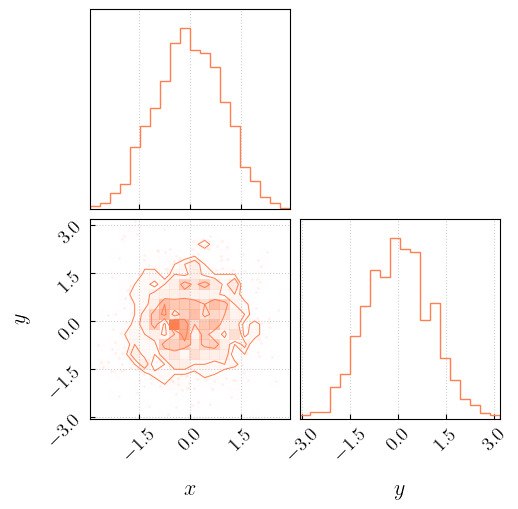

In [24]:
from scipy.stats import multivariate_normal as mn
from corner import corner

n_samps = 1000
samples = mn(np.zeros(2), np.identity(2)).rvs(n_samps)

c = corner(samples, color = 'coral', labels = ['$x$','$y$'], hist_kwargs={'density':True})

The only difference with the previous case is that the mixture needs to be instantiated specifying the bounds for both dimensions.

In [25]:
x_min = -5
x_max = 5
y_min = -5
y_max = 5

bounds = [[x_min, x_max],[y_min, y_max]]

mix_2d = DPGMM(bounds, prior_pars = get_priors(bounds, samples, scale = 3))

The inference runs exactly as before:

In [26]:
for s in tqdm(samples):
    mix_2d.add_new_point(s)
rec = mix_2d.build_mixture()
mix_2d.initialise()

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2940.55it/s]


Let's compare the initial samples with a set of samples drawn from the recovered distribution.

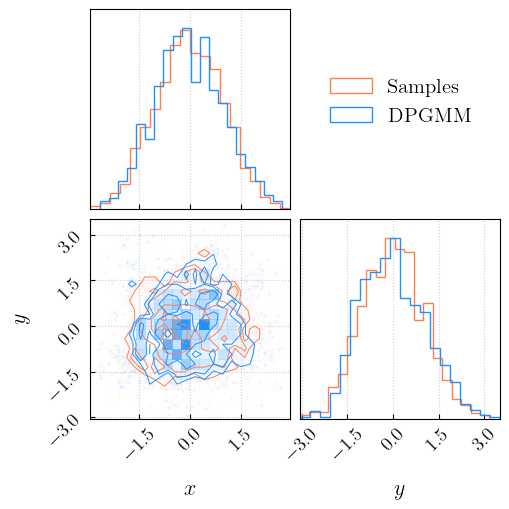

In [27]:
mix_samples = rec.rvs(n_samps)


c = corner(samples, color = 'coral', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{Samples}$'})
c = corner(mix_samples, fig = c, color = 'dodgerblue', labels = ['$x$','$y$'], hist_kwargs={'density':True, 'label':'$\mathrm{DPGMM}$'})
l = plt.legend(loc = 0,frameon = False,fontsize = 15, bbox_to_anchor = (1-0.05, 1.8))

Multiple draws:

In [28]:
n_draws = 100
draws = []

for _ in tqdm(range(n_draws)):
    draws.append(mix_2d.density_from_samples(samples))

100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


We can visualise the inferred distribution using the `figaro.plot.plot_multidim` method:

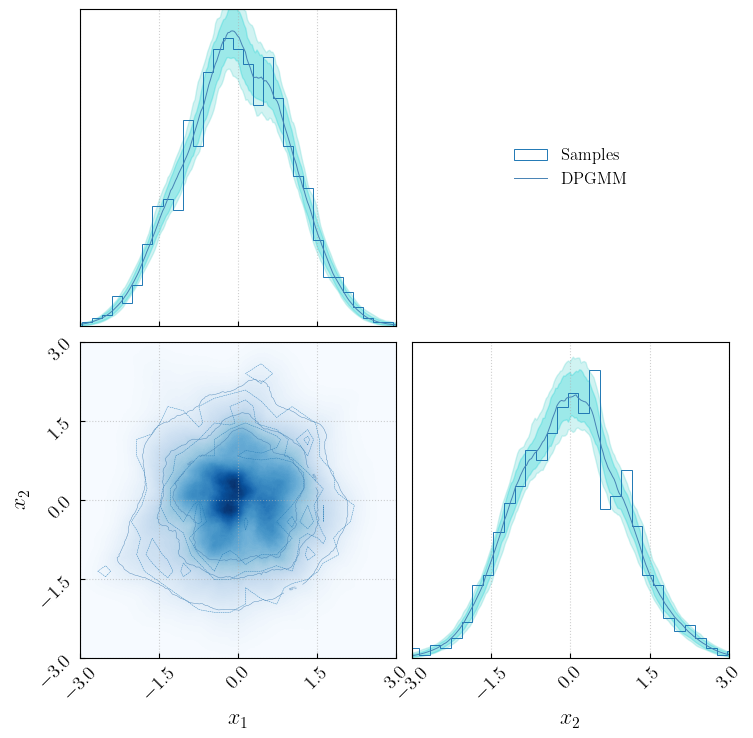

In [29]:
from figaro.plot import plot_multidim

fig = plot_multidim(draws,
                    samples = samples,
                    save = False,
                    )

## Hierarchical inference

Let's assume to have a set of samples $\{x_1,\ldots,x_k\}$ from some probability density $F(x)$. Around each $x_i$, another process generated a set of samples $\mathbf{y}_i = \{y_1^i,\ldots,y_n^i\}$ according to some distribution $f_i(y|x_i)$.   
To give a bit of context, $\{x_1,\ldots,x_k\}$ could be the true masses of the black holes observed by LIGO and Virgo drawn from the mass function $F(x)$ and each $\mathbf{y}_i$ could be the set of single-event primary mass posterior samples drawn from the posterior samples $f_i(y|x_i)$.

In this section we'll see how to use FIGARO to infer $F(x)$ using $\{\mathbf{y}_1,\ldots,\mathbf{y}_k\}$.
In the following example, both $F(x)$ and $f_i(y|x_i)$ are Gaussian distributions.

In [30]:
mu = 30
sigma = 5
n_evs = 100
n_post_samps = 100

mass_function = norm(mu, sigma)
true_masses = mass_function.rvs(n_evs)

single_event_posteriors = [norm(norm(M, s).rvs(), s).rvs(n_post_samps) for M, s in zip(true_masses, np.random.uniform(1,3, size = len(true_masses)))]

First of all, we need to reconstruct the $k$ probability densities $f_i$. For each $y_i$, we can use the DPGMM class.
A proper analysis would require to draw multiple realisations for each posterior distribution. In this example, for the sake of time, we will draw only a handful of realisations for each event.

In [31]:
n_draws = 10
x_min = 1
x_max = 70
bounds = [[x_min, x_max]]

posteriors = []
for event in tqdm(single_event_posteriors, desc = 'Events'):
    draws = []
    mix = DPGMM(bounds, prior_pars = get_priors(bounds, samples = event))
    for _ in range(n_draws):
        draws.append(mix.density_from_samples(event))
    posteriors.append(draws)

Events: 100%|█████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


Once we have the single-event posterior reconstructions, we need the HDPGMM class:

In [32]:
from figaro.mixture import HDPGMM
bounds = [[x_min, x_max]]
hier_mix = HDPGMM(bounds, prior_pars = get_priors(bounds, samples = single_event_posteriors, hierarchical = True))

The methods for this new class are the same we used before.

In [33]:
n_draws_hier = 100
hier_draws = []

for _ in tqdm(range(n_draws_hier)):
    hier_draws.append(hier_mix.density_from_samples(posteriors))

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 11.06it/s]


In the same fashion, we can plot the recovered distribution using the dedicated method:

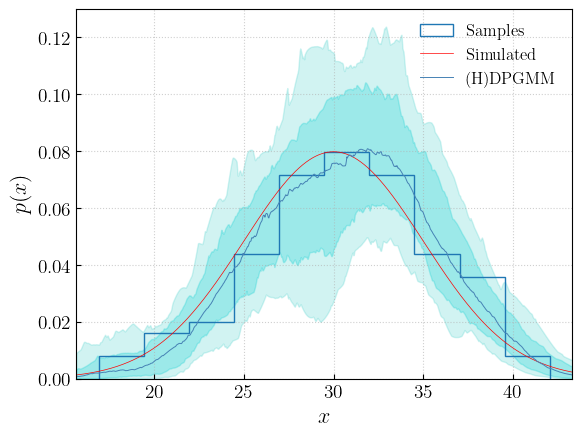

In [34]:
fig = plot_median_cr(hier_draws,
                     samples      = true_masses,
                     injected     = mass_function.pdf,
                     show         = True,
                     hierarchical = True
                     )